In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt


In [2]:
'''
'from google.colab import drive
drive.mount('/content/drive')'
'''

"\n'from google.colab import drive\ndrive.mount('/content/drive')'\n"

In [3]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/college/cephalometry",  # Assuming your main directory is "PetImages"
    labels='inferred',  # Important for 3 classes
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

NotFoundError: Could not find directory /content/drive/MyDrive/college/cephalometry

In [ ]:
#or
'''
import tensorflow as tf
from tensorflow import keras

image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "celphalometry",
    labels='inferred',
    validation_split=0.2,
    subset="both",
    seed=1337,
    batch_size=batch_size,
)

# Dynamic resizing using Resizing layer
train_ds = train_ds.map(lambda x, y: (tf.keras.layers.Resizing(image_size[0], image_size[1])(x), y))
val_ds = val_ds.map(lambda x, y: (tf.keras.layers.Resizing(image_size[0], image_size[1])(x), y))
'''

'\nimport tensorflow as tf\nfrom tensorflow import keras\n\nimage_size = (180, 180)\nbatch_size = 128\n\ntrain_ds, val_ds = keras.utils.image_dataset_from_directory(\n    "celphalometry",\n    labels=\'inferred\',\n    validation_split=0.2,\n    subset="both",\n    seed=1337,\n    batch_size=batch_size,\n)\n\n# Dynamic resizing using Resizing layer\ntrain_ds = train_ds.map(lambda x, y: (tf.keras.layers.Resizing(image_size[0], image_size[1])(x), y))\nval_ds = val_ds.map(lambda x, y: (tf.keras.layers.Resizing(image_size[0], image_size[1])(x), y))\n'

In [ ]:
# alternative
'''
import tensorflow as tf
from tensorflow import keras

image_size = (180, 180)
batch_size = 128

def resize_image(image, label):
    resized_image = tf.image.resize(image, image_size)
    return resized_image, label

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "celphalometry",
    labels='inferred',
    validation_split=0.2,
    subset="both",
    seed=1337,
    batch_size=batch_size,
)

# Apply custom preprocessing function
train_ds = train_ds.map(resize_image)
val_ds = val_ds.map(resize_image)
'''

'\nimport tensorflow as tf\nfrom tensorflow import keras\n\nimage_size = (180, 180)\nbatch_size = 128\n\ndef resize_image(image, label):\n    resized_image = tf.image.resize(image, image_size)\n    return resized_image, label\n\ntrain_ds, val_ds = keras.utils.image_dataset_from_directory(\n    "celphalometry",\n    labels=\'inferred\',\n    validation_split=0.2,\n    subset="both",\n    seed=1337,\n    batch_size=batch_size,\n)\n\n# Apply custom preprocessing function\ntrain_ds = train_ds.map(resize_image)\nval_ds = val_ds.map(resize_image)\n'

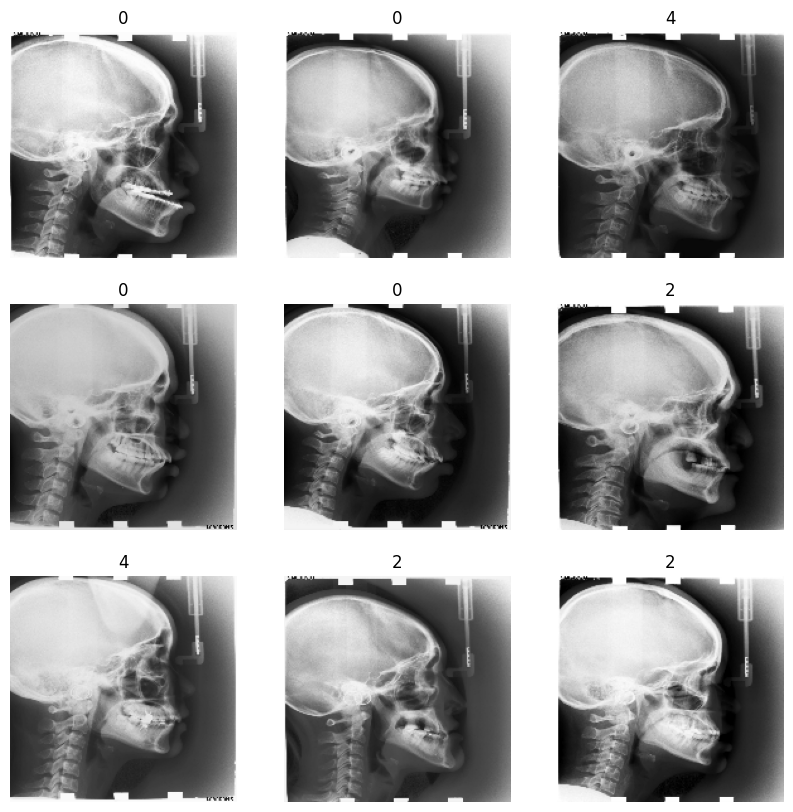

In [ ]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:

data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

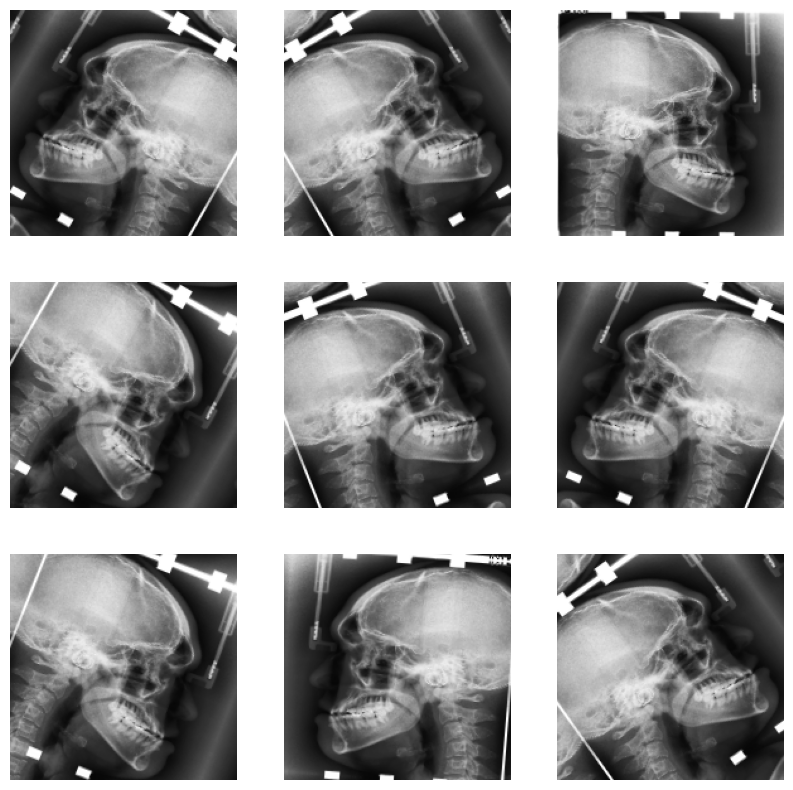

In [ ]:

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [ ]:

# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

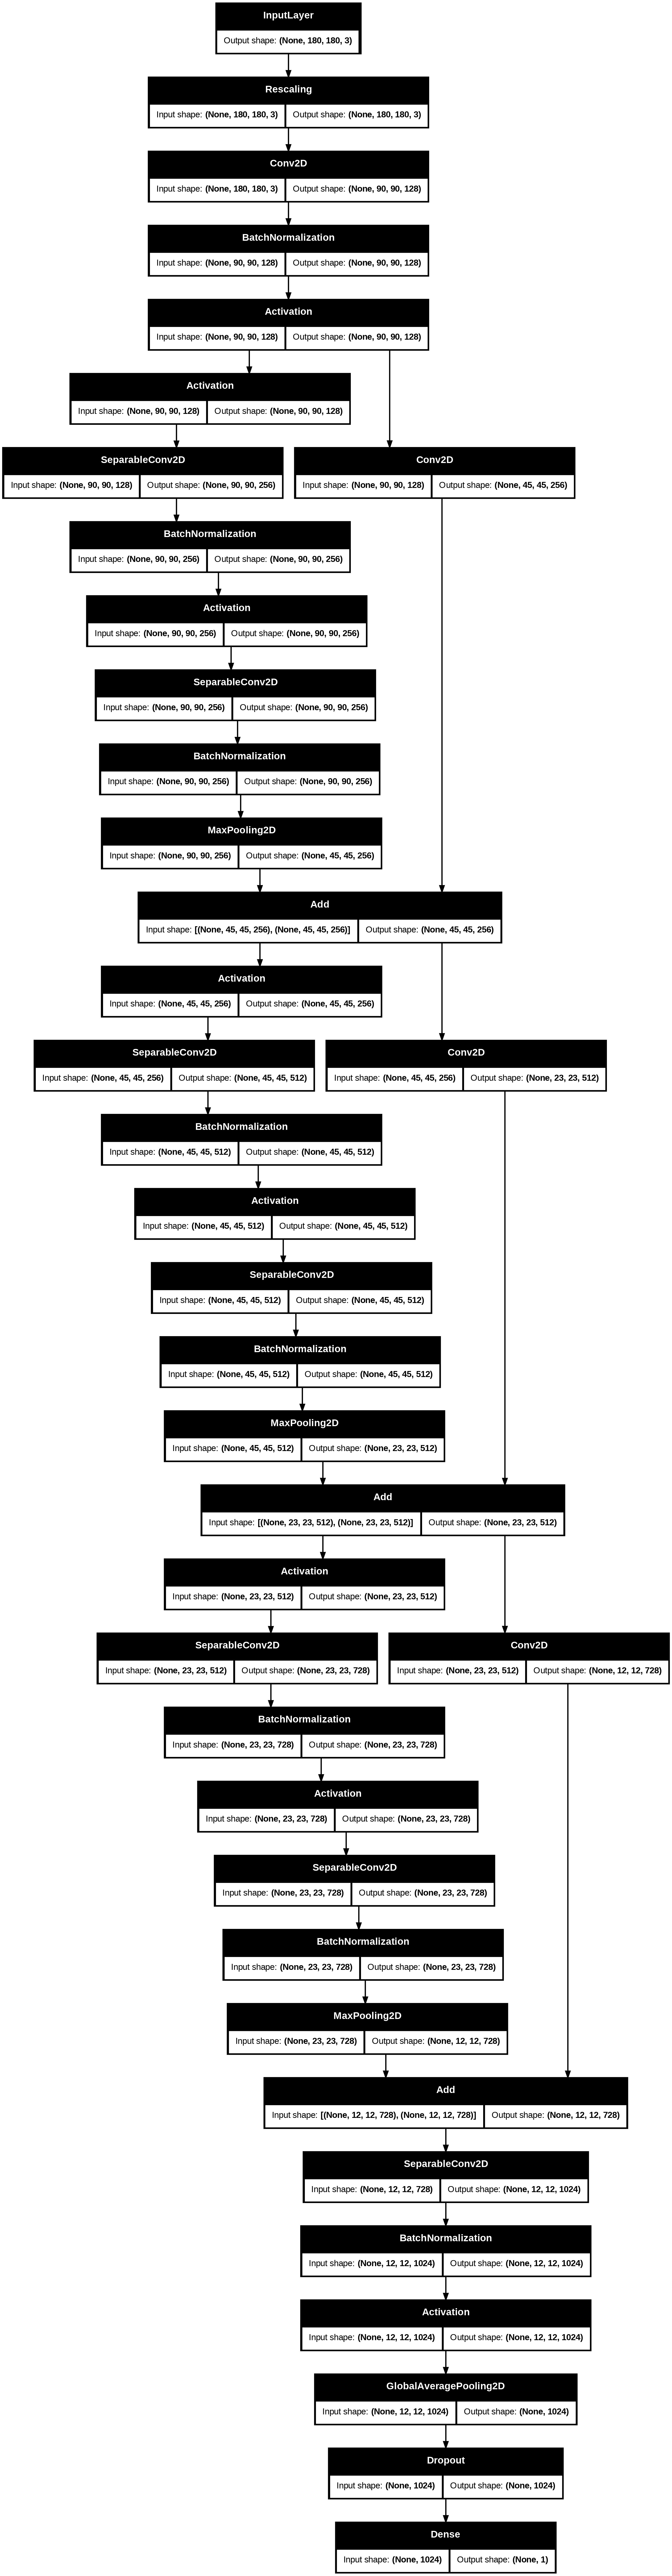

In [ ]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [ ]:

"""
## Train the model
"""

epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 187s 42s/step - acc: 0.5189 - loss: 0.5995 - val_acc: 0.5000 - val_loss: 0.6712
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - acc: 0.1736 - loss: 0.1016 - val_acc: 0.5000 - val_loss: 0.6539
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - acc: 0.0686 - loss: -0.0165 - val_acc: 0.5000 - val_loss: 0.6382
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - acc: 0.0586 - loss: -0.2717 - val_acc: 0.5000 - val_loss: 0.6234
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - acc: 0.0756 - loss: -0.2642 - val_acc: 0.5000 - val_loss: 0.6099
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - acc: 0.0686 - loss: -0.4858 - val_acc: 0.5000 - val_loss: 0.5985
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - acc: 0.0654 - loss: -0.3985 - val_acc: 0.5000 - val_loss: 0.5871
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - acc: 0.0693 - loss: -0.5193 - val_acc: 0.5000 - val_loss: 0.5748
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - acc: 0.0752 - loss: -0.7607 - val_

In [ ]:
# Assuming `model` is your Functional model and you want to add a Dense layer with 5 units and softmax activation:

# Create a new input layer that takes the output of the previous layer
new_input = model.layers[-1].output

# Add the new Dense layer
new_output = layers.Dense(5, activation='softmax')(new_input)

# Create a new model with the added layer
new_model = keras.Model(inputs=model.inputs, outputs=new_output)

# Replace your existing `model` with the new model
model = new_model

In [ ]:
# Load and display the image
# Update the path to the actual location of your image
img_path = "/content/drive/MyDrive/college/cephalometry/Concave/002.jpg"  # Replace '001.jpg' with the actual image file name and adjust 'Concave' if needed
img = keras.utils.load_img(img_path, target_size=image_size)
plt.imshow(img)

# Prepare the image for prediction
img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class probabilities
class_probabilities = predictions[0]  # This will be an array of probabilities for each class

# Display the probabilities for each class
class_labels = ['Concave', 'Convex', 'Plane']
for i, class_name in enumerate(class_labels):
    print(f"This image is {100 * class_probabilities[i]:.2f}% {class_name}.")

NameError: name 'keras' is not defined

In [ ]:
# prompt: show me the accuracy metrics

import numpy as np

# Assuming 'history' object is available from model.fit()
# history = model.fit(...)

# Access accuracy metrics
# Replace with your actual history object if different
# Assuming history contains 'acc' and 'val_acc'
# accuracy = history.history['acc']
# val_accuracy = history.history['val_acc']


# Example: Calculate and print the final accuracy values
# print(f"Final Training Accuracy: {accuracy[-1]:.4f}")
# print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")


# Example: Calculate and print other relevant metrics
# Assuming history also contains loss, val_loss
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# print(f"Final Training Loss: {loss[-1]:.4f}")
# print(f"Final Validation Loss: {val_loss[-1]:.4f}")

# You can also plot the metrics over the epochs:
# import matplotlib.pyplot as plt
# plt.plot(accuracy, label='Training Accuracy')
# plt.plot(val_accuracy, label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


In [ ]:
# prompt: code for basic accuracy metrics

# Assuming 'history' object is available from model.fit()
# Access accuracy metrics
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

# Example: Calculate and print the final accuracy values
print(f"Final Training Accuracy: {accuracy[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")


NameError: name 'history' is not defined

In [ ]:
# prompt: code for basic accuracy metrics

# Assuming `model` is your Functional model and you want to add a Dense layer with 5 units and softmax activation:

# Create a new input layer that takes the output of the previous layer
new_input = model.layers[-1].output
# prompt: code for basic accuracy metrics

# Assuming `model` is your Functional model and you want to add a Dense layer with 5 units and softmax activation:

# Create a new input layer that takes the output of the previous layer
new_input = model.layers[-1].output

# Add the new Dense layer
new_output = layers.Dense(5, activation='softmax')(new_input)

In [ ]:
# prompt: code for basic accuracy metrics

# Assuming `model` is your Functional model and you want to add a Dense layer with 5 units and softmax activation:

# Create a new input layer that takes the output of the previous layer
new_input = model.layers[-1].output

# Add the new Dense layer
new_output = layers.Dense(5, activation='softmax')(new_input)

# Create a new model with the added layer
new_model = keras.Model(inputs=model.inputs, outputs=new_output)

# Replace your existing `model` with the new model
model = new_model

# Compile the new model # This is the line that needs to be added
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),  # Use CategoricalCrossentropy for multi-class
    metrics=['accuracy'],
)

# Assuming 'history' object is available from model.fit()
# Fit the model and store the training history
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

# Access accuracy metrics
accuracy = history.history['accuracy'] # The metric name is 'accuracy', not 'acc'
val_accuracy = history.history['val_accuracy']

# Example: Calculate and print the final accuracy values
print(f"Final Training Accuracy: {accuracy[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")

In [ ]:
# Assuming `model` is your Functional model and you want to add a Dense layer with 5 units and softmax activation:

# Create a new input layer that takes the output of the previous layer
new_input = model.layers[-1].output

# Add the new Dense layer
new_output = layers.Dense(5, activation='softmax')(new_input)

# Create a new model with the added layer
new_model = keras.Model(inputs=model.inputs, outputs=new_output)

# Replace your existing `model` with the new model
model = new_model

# Compile the new model # This is the line that needs to be added
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),  # Use CategoricalCrossentropy for multi-class
    metrics=['accuracy'],
)

In [ ]:
# prompt: write code to display all types of model accuracy

import matplotlib.pyplot as plt
import numpy as np
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Get predictions for the validation set
y_pred = model.predict(val_ds)

# Assuming you have true labels (y_true) for the validation set
# Convert probabilities to class labels (if necessary)
y_pred_classes = np.argmax(y_pred, axis=1)  # For multi-class classification


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Calculate and print classification metrics
print(classification_report(y_true, y_pred_classes)) # Replace y_true with your actual validation labels


# Calculate and display confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import tensorflow as tf

# ... (rest of your code) ...

# Before evaluating the model, one-hot encode the labels in the validation dataset
def one_hot_encode(image, label):
    # Assuming 5 classes (0 to 4)
    one_hot_label = tf.one_hot(label, depth=5)
    return image, one_hot_label

val_ds = val_ds.map(one_hot_encode)

# Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# ... (rest of your code) ...

In [ ]:
# prompt: can you show the actuall accuracy of the model

import matplotlib.pyplot as plt
import numpy as np
# ... (your existing code) ...

# Before evaluating the model, one-hot encode the labels in the validation dataset
def one_hot_encode(image, label):
    # Assuming 5 classes (0 to 4)
    one_hot_label = tf.one_hot(label, depth=5)
    return image, one_hot_label

val_ds = val_ds.map(one_hot_encode)

# Get the true labels from the validation dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1) # Convert one-hot encoded labels back to class indices


# Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Get predictions for the validation set
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  # For multi-class classification

# Calculate and print classification metrics
print(classification_report(y_true, y_pred_classes))

# Calculate and display confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import tensorflow as tf

# ... (your existing code) ...

# Before evaluating the model, one-hot encode the labels in the validation dataset
def one_hot_encode(image, label):
    # Assuming 5 classes (0 to 4)
    # Cast 'label' to tf.int32 before using tf.one_hot
    one_hot_label = tf.one_hot(tf.cast(label, tf.int32), depth=5)
    return image, one_hot_label

val_ds = val_ds.map(one_hot_encode)

# Get the true labels from the validation dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1) # Convert one-hot encoded labels back to class indices


# Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# ... (rest of your code) ...

In [ ]:
import tensorflow as tf

# ... (your existing code) ...

# Before evaluating the model, one-hot encode the labels in the validation dataset
def one_hot_encode(image, label):
    # Assuming 5 classes (0 to 4)
    label = tf.cast(label, tf.int32) # Cast label to tf.int32
    one_hot_label = tf.one_hot(label, depth=5)
    return image, one_hot_label

val_ds = val_ds.map(one_hot_encode)

# Get the true labels from the validation dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1) # Convert one-hot encoded labels back to class indices

# ... (rest of your code) ...

In [ ]:
# prompt: make a confusion marix based on my 5 classes

import matplotlib.pyplot as plt
import numpy as np
# ... (your existing code) ...

# Before evaluating the model, one-hot encode the labels in the validation dataset
def one_hot_encode(image, label):
    # Assuming 5 classes (0 to 4)
    label = tf.cast(label, tf.int32) # Cast label to tf.int32
    one_hot_label = tf.one_hot(label, depth=5)
    return image, one_hot_label

val_ds = val_ds.map(one_hot_encode)

# Get the true labels from the validation dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1) # Convert one-hot encoded labels back to class indices

# Get predictions for the validation set
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  # For multi-class classification

# Calculate and display confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ... (rest of your code) ...
